In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import matplotlib.patches as patches
import os
import cv2
import pickle
#import cvlib as cv
#from cvlib.object_detection import draw_bbox
import random
from collections import defaultdict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout
from keras.models import Sequential, load_model, Model
from keras import Input

In [60]:
train = pd.read_csv("Train.csv")
train = train.sort_values("ClassId").reset_index().drop(["index"], axis = 1)
test = pd.read_csv("Test.csv")

In [61]:
train

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,30,30,5,5,25,25,0,Train/0/00000_00002_00006.png
1,70,74,7,7,64,68,0,Train/0/00000_00004_00014.png
2,72,75,7,6,65,68,0,Train/0/00000_00004_00015.png
3,74,79,7,7,68,72,0,Train/0/00000_00004_00016.png
4,74,80,6,8,67,73,0,Train/0/00000_00004_00017.png
...,...,...,...,...,...,...,...,...
39204,40,43,5,6,35,38,42,Train/42/00042_00002_00024.png
39205,42,44,5,5,37,39,42,Train/42/00042_00002_00025.png
39206,45,47,6,6,40,42,42,Train/42/00042_00002_00026.png
39207,68,71,6,6,62,65,42,Train/42/00042_00003_00028.png


#### Define classes names.

In [62]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }
num_classes = len(classes)

In [85]:
numImages

{0: 210,
 1: 2220,
 2: 2250,
 3: 1410,
 4: 1980,
 5: 1860,
 6: 420,
 7: 1440,
 8: 1410,
 9: 1470,
 10: 2010,
 11: 1320,
 12: 2100,
 13: 2160,
 14: 780,
 15: 630,
 16: 420,
 17: 1110,
 18: 1200,
 19: 210,
 20: 360,
 21: 330,
 22: 390,
 23: 510,
 24: 270,
 25: 1500,
 26: 600,
 27: 240,
 28: 540,
 29: 270,
 30: 450,
 31: 780,
 32: 240,
 33: 689,
 34: 420,
 35: 1200,
 36: 390,
 37: 210,
 38: 2070,
 39: 300,
 40: 360,
 41: 240,
 42: 240}

#### Check the amount of images of each class in the train set to identify possible dataset unbalance. 

Text(40, 1050, 'Pretended Images: 1000.00')

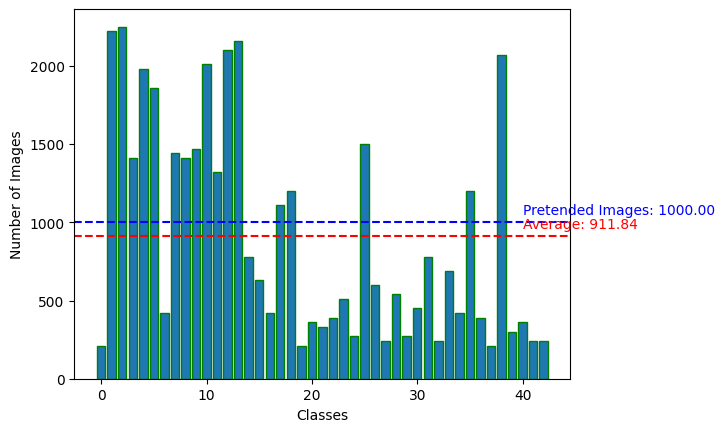

In [63]:
numImages = {}
for i in range(0, num_classes):
    numImages[i] = len(train[train['ClassId'] == i])

plt.bar(numImages.keys(), numImages.values(), edgecolor="green")
plt.xlabel('Classes')
plt.ylabel('Number of Images')
average = np.mean(list(numImages.values()))
plt.axhline(average, color='r', linestyle='--', label='Average')
plt.text(40, average + 50, f"Average: {average:.2f}", color='red')
plt.axhline(1000, color='b', linestyle='--', label='Pretended Images')
plt.text(40, 1000 + 50, f"Pretended Images: {1000:.2f}", color='blue')

#### Check images's resolution by plotting Width and Height. The size of the dots represent the aspect ratio of the image.

Text(0, 0.5, 'Height')

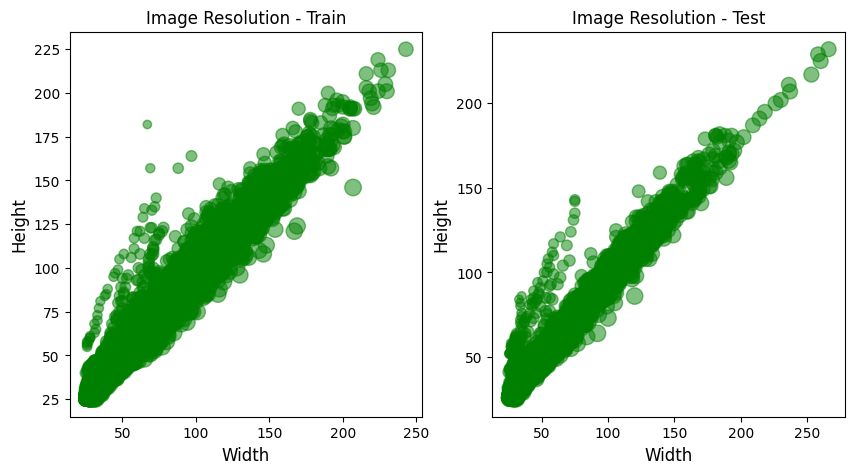

In [64]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
points = ax.scatter(train.Width, train.Height, color='green', alpha=0.5, s=(train.Width/train.Height)*100,  picker=True)
ax.set_title("Image Resolution - Train")
ax.set_xlabel("Width", size=12)
ax.set_ylabel("Height", size=12)
ax2 = fig.add_subplot(122)
points = ax2.scatter(test.Width, test.Height, color='green', alpha=0.5, s=(test.Width/test.Height)*100,  picker=True)
ax2.set_title("Image Resolution - Test")
ax2.set_xlabel("Width", size=12)
ax2.set_ylabel("Height", size=12)

#### Create a function to preprocess the images into a numpy array which is required for the model input.

In [65]:
def image_preprocessing(image):
    image = image.resize((32,32))
    image_array = np.array(image)
    return image_array

#### Define X_train, y_train and roi_train.

In [66]:
X_train = []
y_train = []
for index, path in enumerate(train.Path):
    try:
        image = Image.open(path)
        image_array = image_preprocessing(image)
        X_train.append(image_array)
        y_train.append(train['ClassId'].iloc[index])
    except:
        print("Error in " + path)
X_train = np.array(X_train)
y_train = np.array(y_train)

In [67]:
roi_train = []
for i in range(0, len(train)):
    roi_x1, roi_y1, roi_x2, roi_y2 = train['Roi.X1'].iloc[i], train['Roi.Y1'].iloc[i], train['Roi.X2'].iloc[i], train['Roi.Y2'].iloc[i]
    # Adjust bounding box coordinates for resizing
    resized_roi_x1 = round(roi_x1 * 32 / train['Width'].iloc[i])
    resized_roi_y1 = round(roi_y1 * 32 / train['Height'].iloc[i])
    resized_roi_x2 = round(roi_x2 * 32 / train['Width'].iloc[i])
    resized_roi_y2 = round(roi_y2 * 32 / train['Height'].iloc[i])
    roi_train.append([resized_roi_x1, resized_roi_y1, resized_roi_x2, resized_roi_y2])
    if i in [1000, 5000, 10000, 20000, 30000, 35000]:
        print(i)
roi_train = np.array(roi_train)

1000
5000
10000
20000
30000
35000


#### One hot encode the classes in y_train.

In [68]:
y_train = keras.utils.to_categorical(y_train, num_classes)
print(X_train.shape)
print(y_train.shape)
print(roi_train.shape)

(39209, 32, 32, 3)
(39209, 43)
(39209, 4)


#### Define X_test, y_test and roi_test.

In [69]:
X_test = []
y_test = []
for index, path in enumerate(test.Path):
    try:
        image = Image.open(path)
        image_array = image_preprocessing(image)
        X_test.append(image_array)
        y_test.append(test['ClassId'].iloc[index])
    except:
        print("Error in " + path)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [70]:
roi_test = []
for i in range(0, len(test)):
    roi_x1, roi_y1, roi_x2, roi_y2 = test['Roi.X1'].iloc[i], test['Roi.Y1'].iloc[i], test['Roi.X2'].iloc[i], test['Roi.Y2'].iloc[i]
    # Adjust bounding box coordinates for resizing
    resized_roi_x1 = round(roi_x1 * 32 / test['Width'].iloc[i])
    resized_roi_y1 = round(roi_y1 * 32 / test['Height'].iloc[i])
    resized_roi_x2 = round(roi_x2 * 32 / test['Width'].iloc[i])
    resized_roi_y2 = round(roi_y2 * 32 / test['Height'].iloc[i])
    roi_test.append([resized_roi_x1, resized_roi_y1, resized_roi_x2, resized_roi_y2])
    if i in [1000, 5000, 10000, 20000, 30000, 35000]:
        print(i)
roi_test = np.array(roi_test)

1000
5000
10000


In [71]:
y_test = keras.utils.to_categorical(y_test, num_classes)
print(X_test.shape)
print(y_test.shape)
print(roi_test.shape)

(12630, 32, 32, 3)
(12630, 43)
(12630, 4)


#### Image augmentation and reduction of each class to a 1000.

In [72]:
indexes_to_delete = []
count = 0
for label, images_num in enumerate(numImages.values()):
    if images_num > 1000:
        np.random.shuffle(X_train[count:count+images_num])
        downsize = images_num - 1000
        indexes = [x for x in range(count, count+downsize)]
        indexes_to_delete.append(indexes)
        count = count + images_num
    else:
        count = count + images_num
indexes_to_delete = sum(indexes_to_delete, [])
X_train = np.delete(X_train, indexes_to_delete, axis = 0)
y_train = np.delete(y_train, indexes_to_delete, axis = 0)
roi_train = np.delete(roi_train, indexes_to_delete, axis = 0)
print(X_train.shape)
print(y_train.shape)
print(roi_train.shape)

(27499, 32, 32, 3)
(27499, 43)
(27499, 4)


In [73]:
image_generator = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=.2,
    fill_mode="nearest")

In [74]:
X_train2 = X_train.copy()
y_train2 = y_train.copy()
roi_train2 = roi_train.copy()
count1 = 0
count2 = 0
for label, images_num in enumerate(np.sum(y_train2, axis=0)):  #0 210
    if int(images_num) < 1000:
        augmentation = 1000 - int(images_num)  #790
        while augmentation != 0:
            index = random.randint(count1, count1+int(images_num))  #0 210
           
            image = X_train[index]
            params = image_generator.get_random_transform((1,32,32,3))
            width_shift = params['tx']
            height_shift = params['ty']
            zoom_x = params['zx']
            zoom_y = params['zy']
            image = image_generator.apply_transform(image, params)
            image = np.expand_dims(image, axis = 0)
            
            X_train2 = np.insert(X_train2, count2, image, axis = 0)
            y_train2 = np.insert(y_train2, count2, y_train2[count2], axis = 0)
            
            rx1, ry1, rx2, ry2 = roi_train[index]
            roi_x1 = (rx1 + width_shift) * zoom_x 
            roi_x2 = (rx2 + width_shift) * zoom_x
            roi_y1 = (ry1 - height_shift ) * zoom_y
            roi_y2 = (ry2 - height_shift ) * zoom_y
            roi_train2 = np.insert(roi_train2, count2, np.array([roi_x1, roi_y1, roi_x2, roi_y2]), axis = 0)
            augmentation = augmentation - 1
        count1 = count1 + int(images_num)
        count2 = count2 + 1000
    else:
        count1 = count1 + int(images_num)
        count2 = count2 + 1000

IndexError: index 27499 is out of bounds for axis 0 with size 27499

In [ ]:
print(X_train2.shape)
print(y_train2.shape)
print(roi_train2.shape)

In [57]:
np.sum(y_train, axis=0)

array([ 210., 1000., 1000., 1000., 1000., 1000.,  420., 1000., 1000.,
       1000., 1000., 1000., 1000., 1000.,  780.,  630.,  420., 1000.,
       1000.,  210.,  360.,  330.,  390.,  510.,  270., 1000.,  600.,
        240.,  540.,  270.,  450.,  780.,  240.,  689.,  420., 1000.,
        390.,  210., 1000.,  300.,  360.,  240.,  240.], dtype=float32)

In [58]:
np.sum(y_train2, axis=0)

array([ 610., 1570., 4640.,  450., 2910., 1480.,  150., 1280., 1880.,
       2120., 2280., 1910., 3550., 2090.,  580.,  760., 1090., 1270.,
       1270.,   60.,   90.,  610.,  120.,  150.,   90., 3000.,  460.,
         60.,  150.,  880.,  150., 1180.,   60.,  210.,  120.,  390.,
        120.,   60., 1910.,   90.,   90.,   60., 1000.], dtype=float32)

#### Verify image example from train set.

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


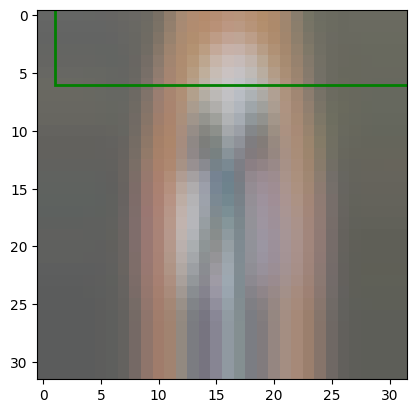

In [52]:
index = 0
r1x, r1y, r2x, r2y = roi_train2[index]
print(y_train2[index])
image_test = X_train2[index]
fig, ax = plt.subplots()
ax.imshow(image_test)
roi_width = (r2x - r1x)
roi_height = (r2y - r1y)
rect = patches.Rectangle((r1x, r1y), roi_width, roi_height, linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(rect)
plt.show()

#### Check the new train set balance

Text(40, 1055, 'threshold: 1000')

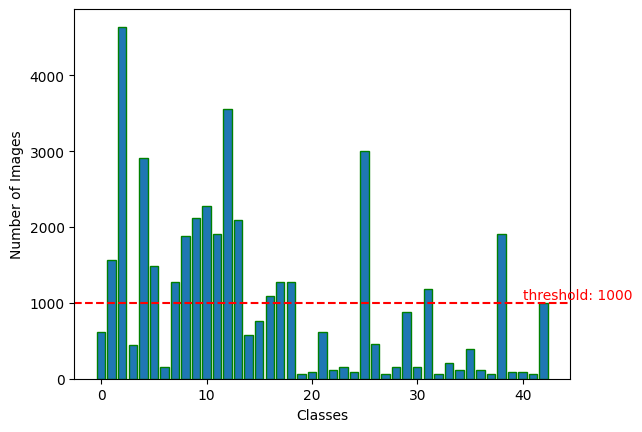

In [55]:
x = np.sum(y_train2, axis = 0)
plt.bar(range(0,43), np.sum(y_train2, axis=0), edgecolor="green")
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.axhline(1000, color='r', linestyle='--', label='1000 threshold')
plt.text(40, 1000 + 55, f"threshold: {1000}", color='red')

#### Normalize input images

In [75]:
X_train = X_train/255
X_test = X_test/255

#### Create model that classifies the images and predicts ROI position in the image.

In [ ]:
#SHUFFLE THE DATA THE SAME WAY
# Generate a random permutation of indices
indices = np.random.permutation(len(X_train))

# Shuffle both arrays using the same indices
X_train = X_train[indices]
y_train = y_train[indices]
roi_train = roi_train[indices]

In [ ]:
# Define the input layer
input_layer = Input(shape=(32, 32, 3))

# Define the model architecture
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(input_layer)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = BatchNormalization(axis=-1)(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = BatchNormalization(axis=-1)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.5)(x)

# Add branches for label and ROI predictions
label_output = Dense(43, activation='softmax', name='label_output')(x)
roi_output = Dense(4, activation='linear', name='roi_output')(x)

# Create a model with both label and ROI outputs
model = Model(inputs=input_layer, outputs=[label_output, roi_output])


In [ ]:
model.compile(optimizer='adam',
              loss={'label_output': 'categorical_crossentropy', 'roi_output': 'mean_squared_error'},
              metrics={'label_output': 'accuracy', 'roi_output': 'mean_squared_error'})

In [ ]:
# Train the model and store the history
history = model.fit(X_train, {'label_output': y_train, 'roi_output': roi_train}, epochs=30, batch_size=32, validation_data=(X_test, [y_test, roi_test]))
with open('CNNHistory.pickle', 'wb') as f:
    pickle.dump(history.history, f)
model.save('CNN.h5')

In [84]:
# Load model history from file
with open('CNNHistory1.pickle', 'rb') as f:
    history = pickle.load(f)
    
model = load_model("CNN1.h5") 

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xea in position 29: invalid continuation byte